In [2]:
### Load libraries
import numpy as np
from functools import reduce
import scipy
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('notebook')
import h5py
import allel
import scipy.spatial
# set size of the labels to be more visible
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

In [3]:
# consider only the ace1 entire region
ace = allel.read_vcf('Aceee.recode.vcf', region='2R:3483099-3497400')

In [4]:
# get genotype of all individuals at position 3491812 index 4170, 3492028 index 4216,
# 3492074 index 4233, 3492202 index 4265
o1 = list(ace['calldata/GT'][4170])
o2 = [l.tolist() for l in o1]
op2 = []
for l in o2:
    x = int("".join(map(str, l)))
    op2.append(x)
for n, i in enumerate(op2):
    if i == 0:
        op2[n] = 'CC'
    elif i == 1:
        op2[n] = 'CT'
    else:
        op2[n] = 'TT'
        
o2 = list(ace['calldata/GT'][4216])
o3 = [l.tolist() for l in o2]
op3 = []
for l in o3:
    x = int("".join(map(str, l)))
    op3.append(x)
for n, i in enumerate(op3):
    if i == 0:
        op3[n] = 'AA'
    elif i == 22:
        op3[n] = 'GG'
    elif i == 2:
        op3[n] = 'AG'
    elif i == 3:
        op3[n] = 'AT'
    elif i == 1:
        op3[n] = 'AC'
    else:
        op3[n] = 'GT'
    
    
o3 = list(ace['calldata/GT'][4233])
o4 = [l.tolist() for l in o3]
op4 = []
for l in o4:
    x = int("".join(map(str, l)))
    op4.append(x)    
for n, i in enumerate(op4):
    if i == 0:
        op4[n] = 'GG'
    elif i == 1:
        op4[n] = 'GA'
    else:
        op4[n] = 'AA'

o4 = list(ace['calldata/GT'][4265])
o5 = [l.tolist() for l in o4]
op5 = []
for l in o4:
    x = int("".join(map(str, l)))
    op5.append(x)   
        
for n, i in enumerate(op5):
    if i == 0:
        op5[n] = 'GG'
    elif i == 22:
        op5[n] = 'CC'
    elif i == 2:
        op5[n] = 'GC'
    else:
        op5[n] = 'GA'

In [5]:
# load sample code
s = list(ace['samples'])

In [6]:
# load sample data
samples = pd.read_csv('samples.meta.txt', sep='\t')
# load population code
pop = list(samples.population)

In [7]:
# construct a data table
df3 = pd.DataFrame(list(zip(pop, s, op2, op3, op4, op5)),
                      columns=['Populations', 'Individuals','L192L(3491812)',
                               'R264R(3492028)', 'G280S(3492074)', 'P322P(3492202)'])

In [8]:
### pivot table

l192l = df3.groupby(['Populations','L192L(3491812)']).size().reset_index(name='Size')
l192l = l192l.pivot_table(
      values=['Size'], index='Populations',
      columns='L192L(3491812)', fill_value=0, aggfunc='mean')
l192l["Total"] = l192l.sum(axis=1)
l192l = l192l.div(l192l["Total"], axis=0)

R264R = df3.groupby(['Populations','R264R(3492028)']).size().reset_index(name='Size')
R264R = R264R.pivot_table(
    values=['Size'], index='Populations',
      columns='R264R(3492028)', fill_value=0, aggfunc='mean')
R264R["Total"] = R264R.sum(axis=1)
R264R = R264R.div(R264R["Total"], axis=0)

G280S = df3.groupby(['Populations','G280S(3492074)']).size().reset_index(name='Size')
G280S = G280S.pivot_table(
    values=['Size'], index='Populations',
      columns='G280S(3492074)', fill_value=0, aggfunc='mean')
G280S["Total"] = G280S.sum(axis=1)
G280S = G280S.div(G280S["Total"], axis=0)

P322P = df3.groupby(['Populations','P322P(3492202)']).size().reset_index(name='Size')
P322P = P322P.pivot_table(
    values=['Size'], index='Populations',
      columns='P322P(3492202)', fill_value=0, aggfunc='mean')
P322P["Total"] = P322P.sum(axis=1)
P322P = P322P.div(P322P["Total"], axis=0)

### save file as csv
l192l.to_csv('l192l.csv')
R264R.to_csv('R264R.csv')
G280S.to_csv('G280S.csv')
P322P.to_csv('P322P.csv')

In [18]:
### read up the file changed
l192l1 = pd.read_csv('l192l.csv', header=0)
R264R1 = pd.read_csv('R264R.csv', header=0)
G280S1 = pd.read_csv('G280S.csv', header=0)
P322P1 = pd.read_csv('P322P.csv', header=0)

In [55]:
df4 = [l192l1, R264R1, G280S1, P322P1]
df5 = reduce(lambda left, right: pd.merge(left, right, on=['Populations'],
                                                 how='outer'), df4)

df5 = df5.round(2)

In [56]:
df6 = df5.T
df6, df6.columns = df6[1:] , df6.iloc[0]
float_col = df6.select_dtypes(include=['object'])
for col in float_col.columns.values:
    df6[col] = df6[col].astype('float64')

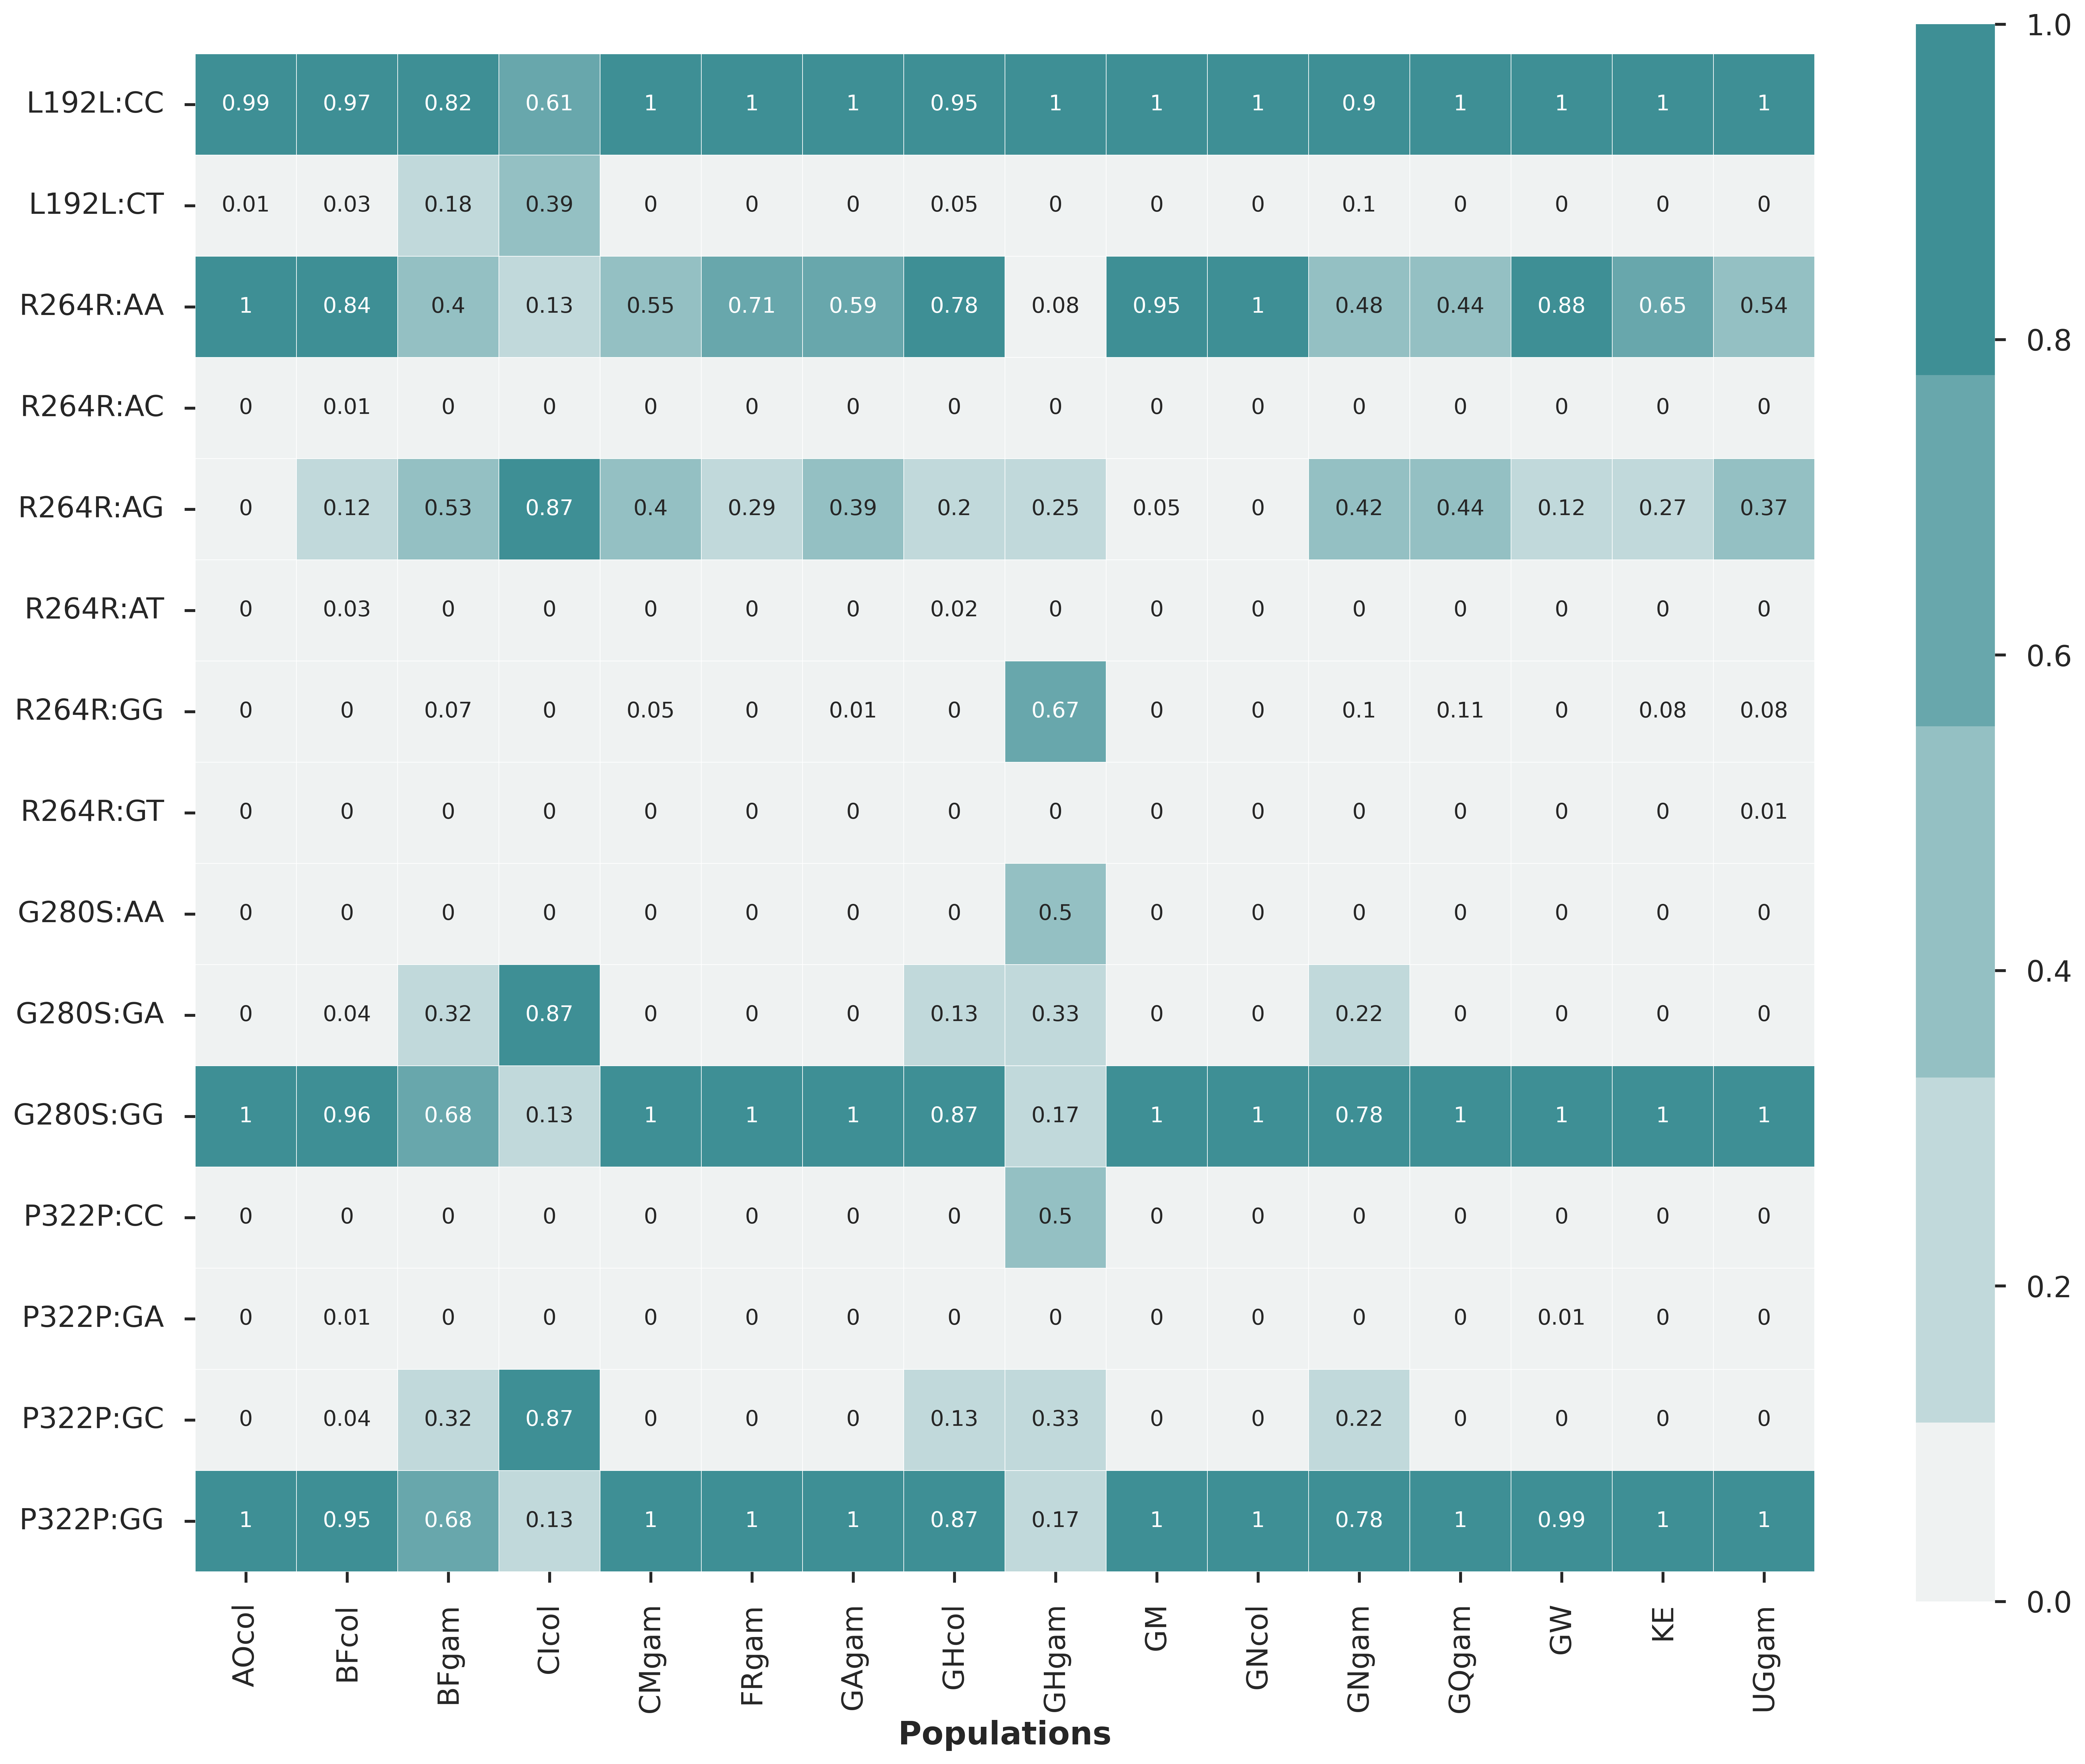

In [57]:
## plot a heatmap showing the alleles frequencies for the 4 mutations present in exon3
cmap = sns.diverging_palette(100, 200, s=80, l=55, n=9)

plt.style.use(['seaborn-poster'])
plt.figure(figsize=(20, 16), dpi=400)

sns.heatmap(df6, annot=True, vmin=0.0, vmax=1,
            linewidth=0.3, square=True, center=0, cmap=cmap)
plt.show()